In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
num_states = 10
prob_next = 0.3
prob_prev = 0.3
prob_self = 1- (prob_next + prob_prev)
prob_edge = 0.1

In [ ]:
prob_matrix = np.zeros((num_states,3))

for i in range(num_states):
  if i == 0:
    prob_matrix[i][0] = 0
    prob_matrix[i][1] = prob_edge
    prob_matrix[i][2] = 1-prob_edge

  elif i == num_states-1:
    prob_matrix[i][0] = 1-prob_edge
    prob_matrix[i][1] = prob_edge
    prob_matrix[i][2] = 0

  else:
    prob_matrix[i][0] = prob_prev
    prob_matrix[i][1] = prob_self
    prob_matrix[i][2] = prob_next

In [ ]:
Es=20
power_max=100
battery_max = 100
gain_max = 1.0
battery_factor = 0.3
discount_factor = 0.99

### Agent

In [ ]:
class Agent(): # actions of agent depends on policy, here we compute what happens after action
  def __init__(self):
    self.noise = 1.0
    self.gain_factor = 1 # power_max / num_states
    self.battery_prob = 1 # battery renew prob

  def channel_next_state(self,i):  # channel transition and it is independent of action

    prob = np.random.rand()

    if i == 1:
      # state 1,
      if prob > prob_edge: # retain same state, that is 1
        return 0
      else:
        return 1 # go to next state

    elif i == num_states: # next state from last state
      if prob > prob_edge:   # retain same state, that is last state
        return 0
      else:
        return -1 # go one state back

    else:
      if prob < prob_prev: # go to previous state
        return -1
      elif prob < prob_prev + prob_self: # retain the same state
        return 0
      else: # go to next state
        return 1

  def state_battery(self,battery,power_transmit): # battery remains and harvesting
  # transition of state: battery level
  # inputs are battery level and action tx power
    rand = np.random.rand()
    is_harvested = -1 # random initialization

    battery_spent = battery_factor * power_transmit # this is known if tx power is fixed

    if rand < self.battery_prob: # this is battery harvesting condition
      new_battery = np.minimum(power_max,battery + Es - battery_spent)
      is_harvested = 1
    else: # no battery harvesting
      new_battery = battery - battery_spent
      is_harvested = 0

    return new_battery, is_harvested

  def next_state_reward(self,init_state, transmit_energy):
    # initial state and action (tx power)
    transition = self.channel_next_state(init_state)  # transition ={-1,0,1}
    new_state = init_state + transition # new channel state after transition

    init_gain = (init_state ) * self.gain_factor # initial state => current state of channel
    new_gain = (new_state) * self.gain_factor # we dont need this

    snr = init_gain * transmit_energy / self.noise # snr based on current channel state

    reward = np.log(1 + snr) # this defines reward

    return new_state, reward

  def joint_state_reward_under_action(self,battery,power_transmit,init_state):

    new_battery, _ = self.state_battery(battery, power_transmit) # new battery state
    new_state, reward = self.next_state_reward(init_state, power_transmit) # new channel state and reward

    return new_state, reward, new_battery


agent = Agent()

In [ ]:
def get_discounted_rewards(rewards): # this function computes discounted cummulative reward
  d_reward = []
  d_reward.append(rewards[0])
  for i in range(1,len(rewards)):
    d_reward.append( pow(discount_factor,i) * rewards[i]  +  d_reward[i-1])

  return d_reward

### Policy1

Irrespective of gain, transmit max-possible power


In [ ]:
class Policy1():
  def __init__(self):
    pass

  def take_action(self,max_power,battery,init_state,battery_threshold):

    if(battery < battery_threshold):
       power_transmitted = 0
    else:
       power_transmitted = max_power

    new_battery, is_harvested = agent.state_battery(battery, power_transmitted)

    if(new_battery < 0):
      power_transmitted = 0
      new_battery = 0

    new_state, reward = agent.next_state_reward(init_state, power_transmitted)

    return new_state, reward, new_battery, is_harvested, power_transmitted

In [ ]:
policy1 = Policy1()
battery = battery_max
time_steps = 1000
max_power = 100
init_state = 8
battery_threshold = 30
rewards = []


for i in range(time_steps):

  new_state, reward, new_battery,is_harvested,power_transmitted = policy1.take_action( max_power, battery, init_state,battery_threshold)
  battery = new_battery
  init_state = new_state

  # print(f"\n------------Time Step {i}-------------")
  # print(f"Energy Harvested {is_harvested}")
  # print(f"power transmited {power_transmitted}")
  # print(f"Remaining Battery {new_battery}",)
  # print(f"Reward {reward}")
  # print("---------------------------------\n")

  rewards.append(reward)

discounted_rewards_1 = get_discounted_rewards(rewards)



In [ ]:
print(f"Outage observed in {rewards.count(0.0)} out of {time_steps} transmissions")
print(f"Average reward: {np.array(rewards).mean()}")
print(f"Total reward: {np.array(rewards).sum()}")
print(f"Cummulative reward: {discounted_rewards_1[-1]}")

Outage observed in 331 out of 1000 transmissions
Average reward: 4.085199109972651
Total reward: 4085.199109972651
Cummulative reward: 446.15686215246325


### Policy2

Power transmission depends on gain.

More Gain : More power Transmitted

In [ ]:
class Policy2(): # higher channel gain, then transmit more power
  def __init__(self): # initialization if required
    pass

  def take_action(self,max_power,battery,current_state,battery_threshold): # action of agent

    if(battery < battery_threshold): # not to transmit if it is less than threshold
       power_transmitted = 0
    else:
       power_transmitted = min(max_power, current_state * 10) # this is okay but need some more understanding

    new_battery, is_harvested = agent.state_battery(battery, power_transmitted) # this is okay

    if(new_battery < 0): # okay for now, we will come back
      power_transmitted = 0
      new_battery = 0

    new_state, reward = agent.next_state_reward(current_state, power_transmitted)

    return new_state, reward, new_battery, is_harvested, power_transmitted

In [ ]:
policy2 = Policy2() # running the policy 2 ( transmit power proportional to battery)
battery = battery_max
time_steps = 1000
max_power = 100
init_state = 8
battery_threshold = 20

rewards = []


for i in range(time_steps):

  new_state, reward, new_battery,is_harvested,power_transmitted = policy2.take_action( max_power, battery, init_state,battery_threshold)
  battery = new_battery
  init_state = new_state

  # print(f"\n------------Time Step {i}-------------")
  # print(f"Energy Harvested {is_harvested}")
  # print(f"power transmited {power_transmitted}")
  # print(f"Remaining Battery {new_battery}",)
  # print(f"New channel state {new_state}",)
  # print(f"Reward {reward}")
  # print("---------------------------------\n")

  rewards.append(reward)

discounted_rewards_2 = get_discounted_rewards(rewards)




In [ ]:
print(f"Outage observed in {rewards.count(0.0)} out of {time_steps} transmissions")
print(f"Average reward: {np.array(rewards).mean()}")
print(f"Total reward: {np.array(rewards).sum()}")
print(f"Cummulative reward: {discounted_rewards_2[-1]}")

Outage observed in 53 out of 1000 transmissions
Average reward: 4.612286825540652
Total reward: 4612.286825540652
Cummulative reward: 483.956674372151


In [ ]:
# for i in range(len(discounted_rewards)):
#   print(round(rewards[i],2), round(rewards[i],2) * 0.8,  round(discounted_rewards[i],2))

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(discounted_rewards_2)

### Policy 2.1

Power transmission depends on gain.

More Gain : More power Transmitted with minimum threshold

In [ ]:
class Policy2_1(): # higher channel gain, then transmit more power
  def __init__(self): # initialization if required
    pass

  def take_action(self,max_power,battery,current_state,battery_threshold): # action of agent

    if(battery < battery_threshold): # not to transmit if it is less than threshold
       power_transmitted = 0
    else:
      if current_state <= 3:
        power_transmitted = 30
      else:
        power_transmitted = min(max_power, current_state * 10) # this is okay but need some more understanding

    new_battery, is_harvested = agent.state_battery(battery, power_transmitted) # this is okay

    if(new_battery < 0): # okay for now, we will come back
      power_transmitted = 0
      new_battery = 0

    new_state, reward = agent.next_state_reward(current_state, power_transmitted)

    return new_state, reward, new_battery, is_harvested, power_transmitted

In [ ]:
policy2_1= Policy2_1() # running the policy 2 ( transmit power proportional to battery)
battery = battery_max
time_steps = 1000
max_power = 100
init_state = 8
battery_threshold = 20

rewards = []


for i in range(time_steps):

  new_state, reward, new_battery,is_harvested,power_transmitted = policy2_1.take_action( max_power, battery, init_state,battery_threshold)
  battery = new_battery
  init_state = new_state

  # print(f"\n------------Time Step {i}-------------")
  # print(f"Energy Harvested {is_harvested}")
  # print(f"power transmited {power_transmitted}")
  # print(f"Remaining Battery {new_battery}",)
  # print(f"New channel state {new_state}",)
  # print(f"Reward {reward}")
  # print("---------------------------------\n")

  rewards.append(reward)

discounted_rewards_2_1 = get_discounted_rewards(rewards)




In [ ]:
print(f"Outage observed in {rewards.count(0.0)} out of {time_steps} transmissions")
print(f"Average reward: {np.array(rewards).mean()}")
print(f"Total reward: {np.array(rewards).sum()}")
print(f"Cummulative reward: {discounted_rewards_2_1[-1]}")

Outage observed in 134 out of 1000 transmissions
Average reward: 4.8639676809450405
Total reward: 4863.96768094504
Cummulative reward: 495.52593441380026


In [ ]:
# for i in range(len(discounted_rewards)):
#   print(round(rewards[i],2), round(rewards[i],2) * 0.8,  round(discounted_rewards[i],2))

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(discounted_rewards_2)

### Policy3

Power transmission depends on gain.

More Gain : Less power Transmitted

In [ ]:
class Policy3(): # power to transmit is inversely prop to channel gain
  def __init__(self):
    pass

  def take_action(self,max_power,battery,init_state,battery_threshold):

    if(battery < battery_threshold): #less than threshold power no transmission
       power_transmitted = 0
    else:
       power_transmitted = min(max_power, (num_states - init_state + 1) * 10)

    new_battery, is_harvested = agent.state_battery(battery, power_transmitted)

    if(new_battery < 0):
      power_transmitted = 0
      new_battery = 0

    new_state, reward = agent.next_state_reward(init_state, power_transmitted)

    return new_state, reward, new_battery, is_harvested, power_transmitted

In [ ]:
policy3 = Policy3()
battery = battery_max
time_steps = 1000
max_power = 100
init_state = 8
battery_threshold = 30
rewards = []



for i in range(time_steps):

  new_state, reward, new_battery, is_harvested, power_transmitted = policy3.take_action( max_power, battery, init_state, battery_threshold)
  battery = new_battery
  init_state = new_state

  # print(f"\n------------Time Step {i}-------------")
  # print(f"Energy Harvested {is_harvested}")
  # print(f"power transmited {power_transmitted}")
  # print(f"Remaining Battery {new_battery}",)
  # print(f"Gain {new_state/10}")
  # print(f"Reward {reward}")
  # print("---------------------------------\n")

  if new_battery < 0:
      print("You've used all your battery")
      break

  rewards.append(reward)

discounted_rewards_3 = get_discounted_rewards(rewards)


In [ ]:
print(f"Outage observed in {rewards.count(0.0)} out of {time_steps} transmissions")
print(f"Average reward: {np.array(rewards).mean()}")
print(f"Total reward: {np.array(rewards).sum()}")
print(f"Cummulative reward: {discounted_rewards_3[-1]}")

Outage observed in 73 out of 1000 transmissions
Average reward: 4.786959828287277
Total reward: 4786.959828287278
Cummulative reward: 496.5517162797167


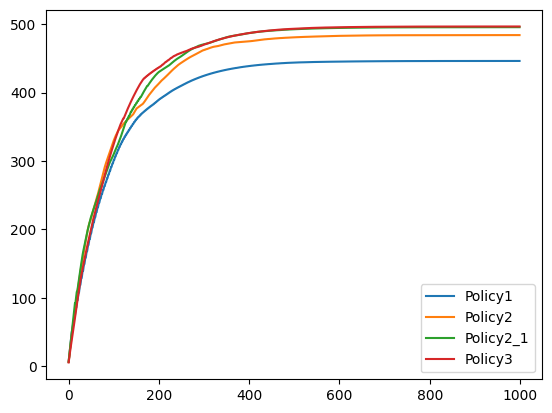

In [ ]:
# discounted_rewards_1
plt.plot(discounted_rewards_1,label="Policy1")

plt.plot(discounted_rewards_2,label="Policy2")
plt.plot(discounted_rewards_2_1,label="Policy2_1")

plt.plot(discounted_rewards_3,label="Policy3")
plt.legend()
plt.show()

### Checking for multiple battery threshold

In [ ]:
# class Policy3():
#   def __init__(self):
#     pass

#   def take_action(self,max_power,battery,init_state,battery_threshold):

#     if(battery < battery_threshold):
#        power_transmitted = 0
#     else:
#        power_transmitted = min(max_power, (num_states - init_state + 1) * 10)

#     new_battery, is_harvested = agent.state_battery(battery, power_transmitted)

#     if(new_battery < 0):
#       power_transmitted = 0
#       new_battery = 0

#     new_state, reward = agent.next_state_reward(init_state, power_transmitted)

#     return new_state, reward, new_battery, is_harvested, power_transmitted

In [ ]:
# policy3 = Policy3()

# battery_threshold = [10,20,30,40,50,60,70,80,90]
# time_steps = 10000


# results = []

# for th in battery_threshold:

#   battery = battery_max
#   max_power = 100
#   init_state = 6
#   rewards = []


#   for i in range(time_steps):

#     new_state, reward, new_battery, is_harvested, power_transmitted = policy3.take_action( max_power, battery, init_state,th)
#     battery = new_battery
#     init_state = new_state


#     rewards.append(reward)

#   results.append([rewards.count(0.0) / time_steps, np.array(rewards).mean(),np.array(rewards).sum()])


# results = np.array(results)

In [ ]:
# policy3 = Policy3()

# battery_threshold = [10,20,30,40,50,60,70,80,90]
# time_steps = 10000


# results = []

# for th in battery_threshold:

#   battery = battery_max
#   max_power = 100
#   init_state = 6
#   rewards = []


#   for i in range(time_steps):

#     new_state, reward, new_battery, is_harvested, power_transmitted = policy3.take_action( max_power, battery, init_state,th)
#     battery = new_battery
#     init_state = new_state


#     rewards.append(reward)

#   results.append([rewards.count(0.0) / time_steps, np.array(rewards).mean(),np.array(rewards).sum()])


# results = np.array(results)

In [ ]:
# results

In [ ]:
# print("10% outage : ", results[:,0][0])
# print("20% outage : ", results[:,0][1])
# print("30% outage : ", results[:,0][2])
# print("40% outage : ", results[:,0][3])
# print("50% outage : ", results[:,0][4])
# print("60% outage : ", results[:,0][5])
# print("70% outage : ", results[:,0][6])
# print("80% outage : ", results[:,0][7])
# print("90% outage : ", results[:,0][8])

In [ ]:
# battery = battery_max
# max_power = 100
# init_state = 6
# rewards = []

# for i in range(10000):


#   new_state, reward, new_battery, is_harvested, power_transmitted = policy3.take_action( max_power, battery, init_state, 10)
#   battery = new_battery
#   init_state = new_state
#   # print(f"\n------------Time Step {i}-------------")
#   # print(f"Energy Harvested {is_harvested}")
#   # print(f"power transmited {power_transmitted}")
#   # print(f"Remaining Battery {new_battery}",)
#   # print(f"Gain {new_state/10}")
#   # print(f"Reward {reward}")
#   # print("---------------------------------\n")

#   rewards.append(reward)


# print(f"Outage observed in {rewards.count(0.0)} out of {time_steps} transmissions")
# print(f"Average reward: {np.array(rewards).mean()}")
# print(f"Cumulative reward: {np.array(rewards).sum()}")